<!-- WARNING: THIS FILE WAS AUTOGENERATED! DO NOT EDIT! -->

In [ ]:
#|eval: false
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

This is part 4 of the [Road to the Top](https://www.kaggle.com/code/jhoward/first-steps-road-to-the-top-part-1) series, in which I show the process I used to tackle the [Paddy Doctor](https://www.kaggle.com/competitions/paddy-disease-classification) competition. The first three parts show the process I took that lead to four 1st place submissions. This part onwards discusses various extensions and advanced tricks you might want to consider -- but which I don't promise will necessarily help your score (you'll need to do your own experiments to figure this out!) If you haven't read the rest of this series yet, I'd suggest starting at [part 1](https://www.kaggle.com/code/jhoward/first-steps-road-to-the-top-part-1).

In this notebook we're going to build a model that doesn't just predict what disease the rice paddy has, but also predicts what kind of rice is shown.

This might sound like a bad idea. After all, doesn't that mean that the model has *more* to do? Mightn't it get rather distracted from its main task, which is to identify paddy disease?

Perhaps... But in previous projects I've often found the opposite to be true, especially when training for quite a few epochs. By giving the model more signal about what is present in a picture, it may be able to use this information to find more interesting features that predict our target of interest. For instance, perhaps some of the features of disease change between varieties.

## Multi-output `DataLoader`

First we'll repeat the steps we used last time to access the data and ensure all the latest libraries are installed:

In [ ]:
#|eval: false
comp = 'paddy-disease-classification'
path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')
from fastai.vision.all import *
set_seed(42)

from fastcore.parallel import *
trn_path = path/'train_images'

Here's the CSV that Kaggle provides, showing the variety of rice contained in each image -- we'll make `image_id` the index of our data frame so that we can look up images directly to grab their variety:

In [ ]:
#|eval: false
df = pd.read_csv(path/'train.csv', index_col='image_id')
df.head()

,label,variety,age
image_id,,,
100330.jpg,bacterial_leaf_blight,ADT45,45
100365.jpg,bacterial_leaf_blight,ADT45,45
100382.jpg,bacterial_leaf_blight,ADT45,45
100632.jpg,bacterial_leaf_blight,ADT45,45
101918.jpg,bacterial_leaf_blight,ADT45,45


Pandas uses the `loc` attribute to look up rows by index. Here's how we can get the variety of image `100330.jpg`, for instance:

In [ ]:
#|eval: false
df.loc['100330.jpg', 'variety']

'ADT45'

Our DataBlock will be using `get_image_files` to get the list of training images, which returns `Path` objects. Therefore, to look up an item to get its variety, we'll need to pass its `name`. Here's a function which does just that:

In [ ]:
#|eval: false
def get_variety(p): return df.loc[p.name, 'variety']

We're now ready to create our `DataLoaders`. To do this, we'll use the `DataBlock` API, which is a flexible and convenient way to plug pieces of a data processing pipeline together:

In [ ]:
#|eval: false
dls = DataBlock(
    blocks=(ImageBlock,CategoryBlock,CategoryBlock),
    n_inp=1,
    get_items=get_image_files,
    get_y = [parent_label,get_variety],
    splitter=RandomSplitter(0.2, seed=42),
    item_tfms=Resize(192, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75)
).dataloaders(trn_path)

/home/ben/mambaforge/envs/cfast/lib/python3.11/site-packages/fastai/data/transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(col):


Here's an explanation of each line:

```python
blocks=(ImageBlock,CategoryBlock,CategoryBlock),
```

The `DataBlock` will create 3 things from each file: an image (the contents of the file), and 2 categorical variables (the disease and the variety).

```python
n_inp=1,
```

There is `1` input (the image) -- and therefore the other two variables (the two categories) are outputs.

```python
get_items=get_image_files,
```

Use `get_image_files` to get a list of inputs.

```python
get_y = [parent_label,get_variety],
```

To create the two outputs for each file, call two functions: `parent_label` (from fastai) and `get_variety` (defined above).

```python
splitter=RandomSplitter(0.2, seed=42),
```

Randomly split the input into 80% train and 20% validation sets.

```python
item_tfms=Resize(192, method='squish'),
batch_tfms=aug_transforms(size=128, min_scale=0.75)
```

These are the same item and batch transforms we've used in previous notebooks.

Let's take a look at part of a batch of this data:

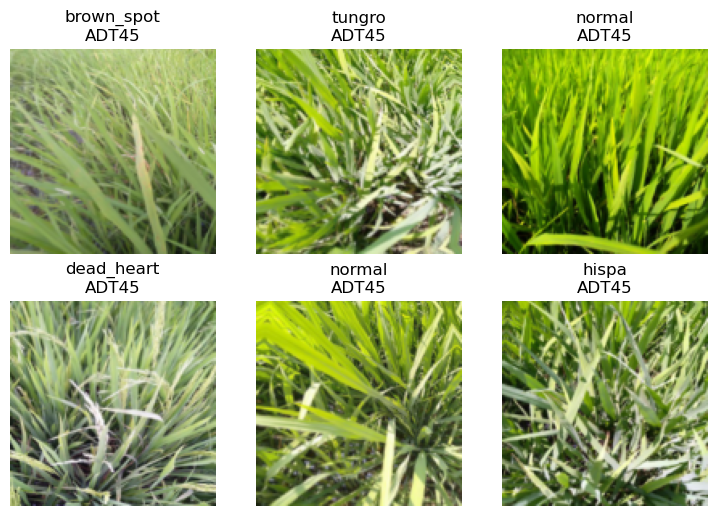

In [ ]:
#|eval: false
dls.show_batch(max_n=6)

We can see that fastai has created both the image input and two categorical outputs that we requested!

## Replicating the disease model

Now we'll replicate the same disease model we've made before, but have it work with this new data.

The key difference is that our metrics and loss will now receive three things instead of two: the model outputs (i.e. the metric and loss function inputs), and the two targets (disease and variety). Therefore, we need to define slight variations of our metric (`error_rate`) and loss function (`cross_entropy`) to pass on just the `disease` target:

In [ ]:
#|eval: false
def disease_err(inp,disease,variety): return error_rate(inp,disease)
def disease_loss(inp,disease,variety): return F.cross_entropy(inp,disease)

We're now ready to create our learner.

There's just one wrinkle to be aware of. Now that our `DataLoaders` is returning multiple targets, fastai doesn't know how many outputs our model will need. Therefore we have to pass `n_out` when we create our `Learner` -- we need `10` outputs, one for each possible disease:

In [ ]:
#|eval: false
arch = 'convnext_small'
learn = vision_learner(dls, arch, loss_func=disease_loss, metrics=disease_err, n_out=10).to_fp16()
lr = 0.01

When we train this model we should get similar results to what we've seen with similar models before:

In [ ]:
#|eval: false
learn.fine_tune(5, lr)

epoch,train_loss,valid_loss,disease_err,time
0,1.444394,1.143909,0.330130,00:58


/home/ben/mambaforge/envs/cfast/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


epoch,train_loss,valid_loss,disease_err,time
0,0.693077,0.661676,0.216242,00:59
1,0.487885,0.528561,0.151370,00:57
2,0.266342,0.241238,0.067275,00:57
3,0.141410,0.154409,0.049495,01:03
4,0.077816,0.126971,0.036040,00:58


## Multi-target model

In order to predict both the probability of each disease, and of each variety, we'll now need the model to output a tensor of length 20, since there are 10 possible diseases, and 10 possible varieties. We can do this by setting `n_out=20`:

In [ ]:
#|eval: false
learn = vision_learner(dls, arch, n_out=20).to_fp16()

We can define `disease_loss` just like we did previously, but with one important change: the input tensor is now length 20, not 10, so it doesn't match the number of possible diseases. We can pick whatever part of the input we want to be used to predict disease. Let's use the first 10 values:

In [ ]:
#|eval: false
def disease_loss(inp,disease,variety): return F.cross_entropy(inp[:,:10],disease)

That means we can do the same thing for predicting variety, but use the last 10 values of the input, and set the target to `variety` instead of `disease`:

In [ ]:
#|eval: false
def variety_loss(inp,disease,variety): return F.cross_entropy(inp[:,10:],variety)

Our overall loss will then be the sum of these two losses:

In [ ]:
#|eval: false
def combine_loss(inp,disease,variety): return disease_loss(inp,disease,variety)+variety_loss(inp,disease,variety)

It would be useful to view the error rate for each of the outputs too, so let's do the same thing for out metrics:

In [ ]:
#|eval: false
def disease_err(inp,disease,variety): return error_rate(inp[:,:10],disease)
def variety_err(inp,disease,variety): return error_rate(inp[:,10:],variety)

err_metrics = (disease_err,variety_err)

It's useful to see the loss for each of the outputs too, so we'll add those as metrics:

In [ ]:
#|eval: false
all_metrics = err_metrics+(disease_loss,variety_loss)

We're now ready to create and train our `Learner`:

In [ ]:
#|eval: false
learn = vision_learner(dls, arch, loss_func=combine_loss, metrics=all_metrics, n_out=20).to_fp16()

In [ ]:
#|eval: false
learn.fine_tune(5, lr)

epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,2.542228,1.576215,0.328208,0.156175,1.073929,0.502286,00:56


epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,1.099259,0.792864,0.179721,0.081691,0.539787,0.253077,01:06
1,0.746134,0.629489,0.140317,0.059106,0.458522,0.170967,01:09
2,0.426638,0.408613,0.080250,0.040846,0.272228,0.136385,01:08
3,0.210059,0.182956,0.041326,0.009130,0.140796,0.042160,01:03
4,0.116933,0.168466,0.042768,0.007689,0.131138,0.037329,01:02


## Conclusion

So, is this useful?

Well... if you actually want a model that predicts multiple things, then yes, definitely! But as to whether it's going to help us better predict rice disease, I honestly don't know. I haven't come across any research that tackles this important question: when can a multi-target model improve the accuracy of the individual targets compared to a single target model? (That doesn't mean it doesn't exist of course -- perhaps it does and I haven't found it yet...)

I've certainly found in previous projects that there are cases where improvements to single targets can be made by using a multi-target model. I'd guess that it'll be most useful when you're having problems with overfitting. So try doing this with more epochs, and let me know how you go!

If you found this notebook useful, please remember to click the little up-arrow at the top to upvote it, since I like to know when people have found my work useful, and it helps others find it too. And if you have any questions or comments, please pop them below -- I read every comment I receive.

In [ ]:
#|eval: false
# This is what I use to push my notebook from my home PC to Kaggle
if not iskaggle:
    push_notebook('jhoward', 'multi-target-road-to-the-top-part-4',
                  title='Multi-target: Road to the Top, Part 4',
                  file='11-multitask.ipynb',
                  competition=comp, private=False, gpu=True)